# Design the paired states with sequence symmetry, sampling backbones for MPNN while maintaining sequence realism

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_shifties
running on node: dig194


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Design the paired states

In [3]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "05_design_paired_states"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/04_pair_bound_states/paired_states.list",
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.msd.two_state_design_paired_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="6G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Run the following command with your desired environment active:
sbatch -a 1-836 /mnt/projects/crispy_shifty/projects/crispy_shifties/05_design_paired_states/run.sh


### Collect scorefiles of designed paired states and concatenate

In [6]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "05_design_paired_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [7]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))
scores_df = scores_df.convert_dtypes()

  0%|          | 0/1028 [00:00<?, ?it/s]

### Setup for plotting

In [8]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [9]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [term for term in scores_df.columns if term not in beta_nov16_terms]
]
print(len(scores_df))

1028


In [10]:
print(list(scores_df.columns))

['bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'interface', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score', 'score_per_res', 'score_per_res_parent', 'score_per_res_x', 'seed', 's

In [11]:
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

### Filter extreme outliers and change some dtypes

In [12]:
scores_df["score_per_res"] = scores_df["score_per_res"].astype(float)
scores_df["score_per_res_x"] = scores_df["score_per_res_x"].astype(float)
scores_df["ss_sc"] = scores_df["ss_sc"].astype(float)
scores_df["time"] = scores_df["time"].astype(float)

query = "score_per_res < 0"
sample_df = scores_df.query(query)

### Plot Rosetta scores

4it [00:00, 11.58it/s]


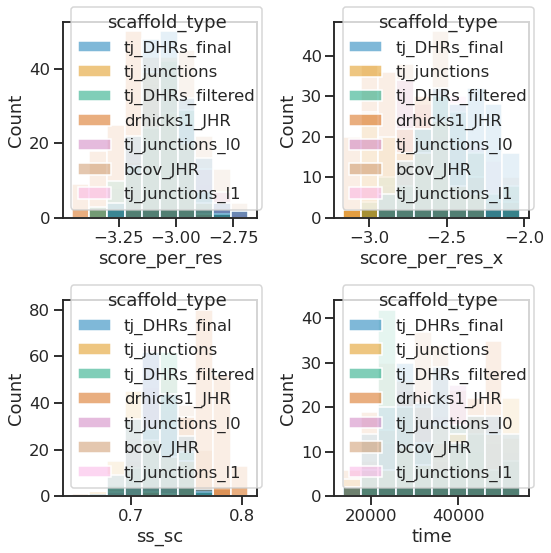

In [13]:
cols = [
    "score_per_res",
    "score_per_res_x",
    "ss_sc",
    "time",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="scaffold_type",
)
plt.savefig(os.path.join(output_path, "rosetta_scores.png"))

4it [00:00, 26.64it/s]


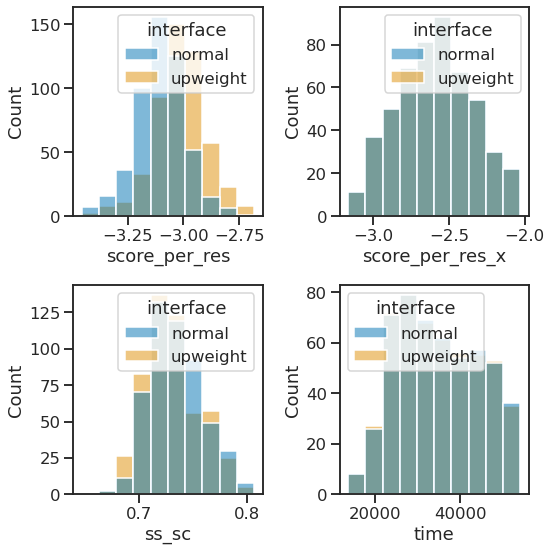

In [14]:
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="interface",
)

<Figure size 1152x1152 with 0 Axes>

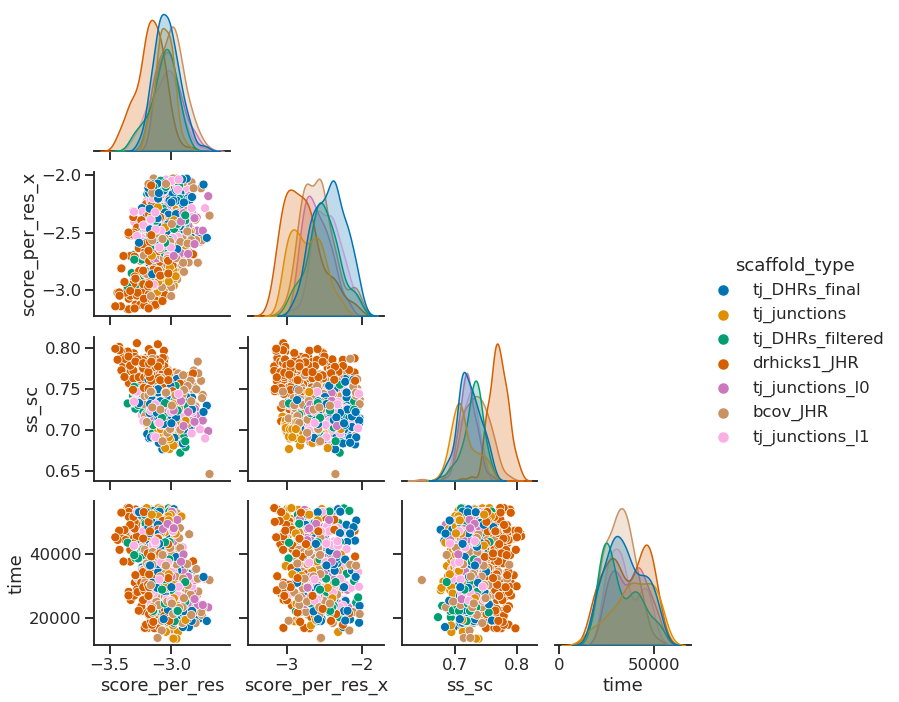

In [15]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="scaffold_type",
)
plt.savefig(os.path.join(output_path, "rosetta_scores_paired.png"))

<Figure size 1152x1152 with 0 Axes>

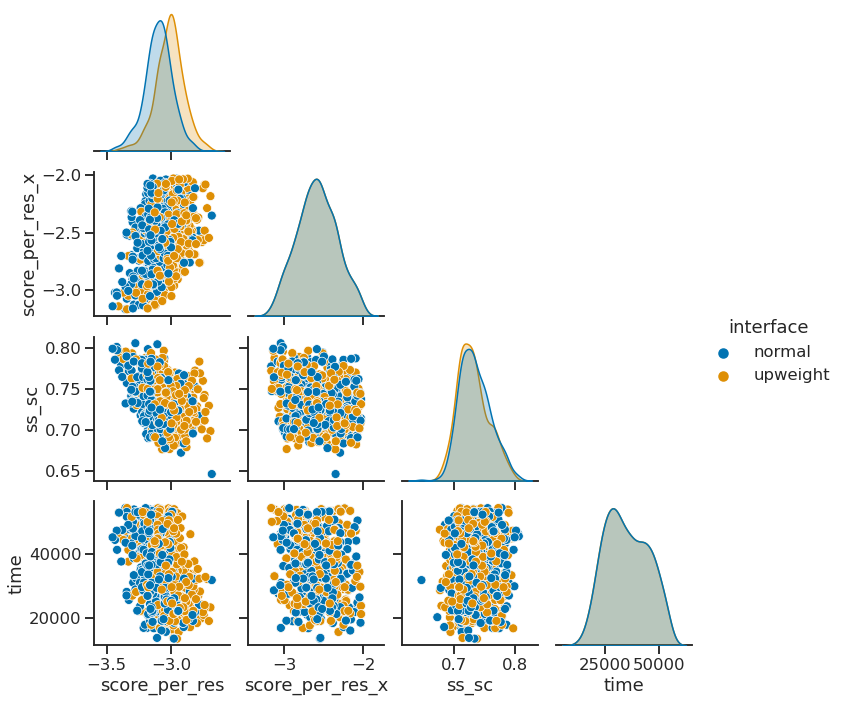

In [16]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="interface",
)

<Figure size 1152x1152 with 0 Axes>

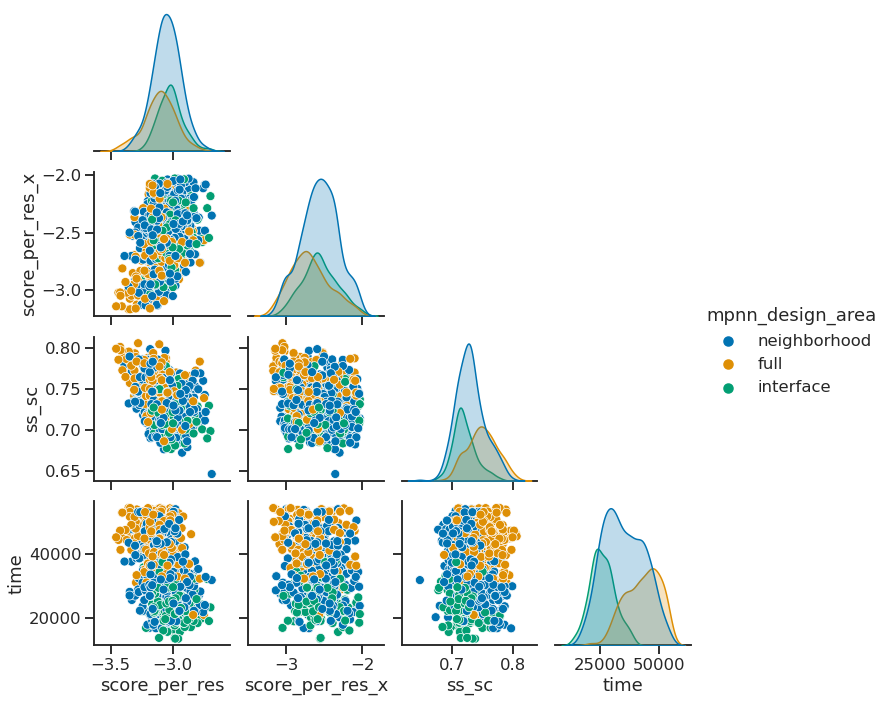

In [17]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="mpnn_design_area",
)

### Filter out obviously bad decoys

In [18]:
query = "score_per_res < -2.75"
filtered = sample_df.query(query)
len(filtered)

1020

In [20]:
print(len(set([v for v in filtered.parent.values if len(v) == 5])))

20


### Save a list of outputs

In [21]:
simulation_name = "05_design_paired_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "designed_paired_states.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/1020 [00:00<?, ?it/s]

### Prototyping blocks

test `design_paired_state`

In [ ]:
%%time
import pyrosetta

pyrosetta.init(
    "-corrections::beta_nov16 \
    -indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5"
)

sys.path.insert(0, "/projects/crispy_shifty/")
from crispy_shifty.protocols.msd import two_state_design_paired_state

t = two_state_design_paired_state(
        None,
        **{
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/04_pair_bound_states/decoys/0001/04_pair_bound_states_331c8b82841d4de280ff3db199bb973f.pdb.bz2'
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
d = dict(tppose.pose.scores)
from crispy_shifty.protocols.design import beta_nov16_terms

d = {k: v for k, v in d.items() if k not in beta_nov16_terms}

In [ ]:
d

test `almost_linkres`

In [ ]:
from pyrosetta.rosetta.core.select.residue_selector import (
    OrResidueSelector,
    ResidueIndexSelector,
)

from crispy_shifty.protocols.design import (
    gen_movemap,
    gen_std_layer_design,
    gen_task_factory,
)
from crispy_shifty.protocols.msd import almost_linkres

pyrosetta.init(
    "-corrections::beta_nov16 true \
    -packing:precompute_ig true \
    "
)

mm = gen_movemap()
sfxn = pyrosetta.create_score_function("beta_nov16.wts")
ld = gen_std_layer_design()

# make some silly selectors

pose = pyrosetta.io.pose_from_file("foo.pdb")
print(pose.chain_end(1))
print(pose.chain_end(2))
print(pose.chain_end(3))

sel1 = ResidueIndexSelector("108,109,110,111,112")
sel2 = ResidueIndexSelector("362,363,364,365,366")
sel3 = ResidueIndexSelector("221,222,223,224,225")
pre_design_sel = OrResidueSelector(sel1, sel2)
design_sel = OrResidueSelector(pre_design_sel, sel3)

tf = gen_task_factory(
    design_sel=design_sel,
    layer_design=ld,
)

tm = almost_linkres(
    pose=pose,
    movemap=mm,
    residue_selectors=[sel1, sel2],
    scorefxn=sfxn,
    task_factory=tf,
    repeats=1,
)

In [ ]:
pose.dump_pdb("baz.pdb")